In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from pybaseball import statcast_batter, playerid_lookup

In [105]:
# select player, season, stadium, game time, and event outcome
FIRST_NAME = "Ernie"
LAST_NAME = "Clement"
SEASON = 2025

# park selection: use three letter team abbreviation or "ALL"
PARK_TEAM = "TOR"

# game type:
# "R" = Regular season
# "P" = Postseason
# "ALL" = Both
GAME_TYPE = "R"

# outcome filter: "home_run", "hits", "all"
OUTCOME_FILTER = "all"

In [106]:
# OPTIONAL
# select specific game and inning
# used for inning-by-inning or near real-time game analysis
GAME_DATE = None          # format: "YYYY-MM-DD" or None
GAME_PK = None            # preferred for live games
INNING = None             # inning number or None
INNING_TOPBOT = None      # "Top", "Bot", or None

# Live game refresh toggle
# If True, Statcast data will be re-downloaded instead of using cache
REFRESH_LIVE_GAME = False

In [107]:
# use player name entered above to look up Statcast ID number
def lookup_statcast_id(first_name, last_name):

    lookup = playerid_lookup(last_name, first_name)

    if lookup.empty:
        raise ValueError("Player not found. Check spelling.")

    player_id = int(lookup.iloc[0]["key_mlbam"])

    print(f"Statcast ID found for {first_name} {last_name}: {player_id}")

    return player_id


In [108]:
CACHE_DIR = "data_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# creates a cache file of Statcast data for player selected
# file name will be statcast_(player number)_(season selected).csv
player_id = lookup_statcast_id(FIRST_NAME, LAST_NAME)
cache_file = f"{CACHE_DIR}/statcast_{player_id}_{SEASON}.csv"

if os.path.exists(cache_file) and not REFRESH_LIVE_GAME:
    print(f"Loading cached data: {cache_file}")
    df = pd.read_csv(cache_file)
    print(f"Loaded {len(df)} rows from cache")

else:
    print("Downloading Statcast data from Baseball Savant...")
    start_date = f"{SEASON}-03-01"
# adjust end date to -11-30" to include post season stats
    end_date = f"{SEASON}-10-01"

# retrieve Statcast data using python interface pybaseball
# from Baseball Savant API for selected player and season
    df = statcast_batter(start_date, end_date, player_id)

    if df.empty:
        raise ValueError("Statcast query returned no data.")

# statcast has one row per hit/batter ball event
# total number of rows collected and saved in the .csv file is noted below
    df.to_csv(cache_file, index=False)
    print(f"Cached {len(df)} rows to {cache_file}")


Statcast ID found for Ernie Clement: 676391
Loading cached data: data_cache/statcast_676391_2025.csv
Loaded 2204 rows from cache


In [109]:
# game type filter execution
if GAME_TYPE != "ALL":
    df = df[df["game_type"] == GAME_TYPE]

# park filter
if PARK_TEAM != "ALL":
    df = df[df["home_team"] == PARK_TEAM]

# outcome filter
if OUTCOME_FILTER == "home_run":
    df = df[df["events"] == "home_run"]

elif OUTCOME_FILTER == "hits":
    df = df[df["events"].isin(["single", "double", "triple", "home_run"])]

elif OUTCOME_FILTER == "all":
    df = df[df["events"].notna()]

In [110]:
# game and inning filter execution
if GAME_PK is not None:
    df = df[df["game_pk"] == GAME_PK]

elif GAME_DATE is not None:
    df = df[df["game_date"] == GAME_DATE]

if INNING is not None:
    df = df[df["inning"] == INNING]

if INNING_TOPBOT is not None:
    df = df[df["inning_topbot"] == INNING_TOPBOT]

In [111]:
# remove rows without spray coordinates
df = df.dropna(subset=["hc_x", "hc_y"])

# how many events/rows are left after filtering
print(f"Batted balls after filtering: {len(df)}")

Batted balls after filtering: 253


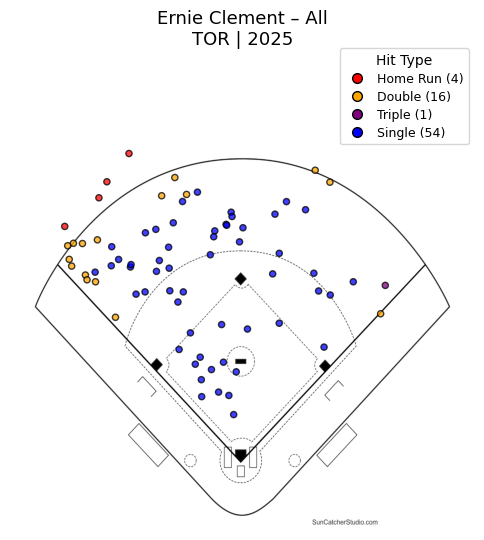

In [112]:
# Plot Visualization

# create figure and access axes for plotting and layout control
# gca = get current axes
plt.figure(figsize=(6, 7))
ax = plt.gca()

# axes limits and orientation to match statcast data
ax.set_xlim(0, 250)
# inverts y axis so home plate (0) is at the bottom of the visualization
ax.set_ylim(250, 0)
# ensures equal scaling of x and y axis
ax.set_aspect("equal")
# turns off axis ticks
ax.axis("off")

# load background field image for visual context
field_img = mpimg.imread("assets/baseball_field.png")

# maps image to same coordinates as the statcast data
ax.imshow(
    field_img,
    extent=[0, 250, 250, 0],
    origin="upper",
    zorder=0
)

# assign colors to different hit types
# editable to user's preference
color_map = {
    "home_run": "red",
    "double": "orange",
    "triple": "purple",
    "single": "blue"
}

# when showing all hits, explicitly limit to known hit events
if OUTCOME_FILTER == "all":
    df = df[df["events"].isin(color_map.keys())]

# remove rows without spray coordinates
df = df.dropna(subset=["hc_x", "hc_y"])

# map colors after filtering so index matches
colors = df["events"].map(color_map)

# safety check
if colors.isna().any():
    raise ValueError("Unmapped event types detected in color assignment.")



# plots location of each hit from the statcast data x and y coordinates
# notes to use the colors mapped above
# s= sets the marker size
# edgecolors is the outline of each hit event marker
# zorder ensures hit markers are overtop of the background image
ax.scatter(
    df["hc_x"],
    df["hc_y"],
    c=colors,
    s=20,
    alpha=0.75,
    edgecolors="black",
    zorder=2
)

# title at top of visualization
# notes players name, hit type mapped, specific park, the season used
ax.set_title(
    f"{FIRST_NAME} {LAST_NAME} – {OUTCOME_FILTER.replace('_',' ').title()}\n"
    f"{PARK_TEAM if PARK_TEAM != 'ALL' else 'All Parks'} | {SEASON}",
    fontsize=13,
    pad=15
)

# add legend when all hit types are selected
if OUTCOME_FILTER == "all":

    event_counts = df["events"].value_counts()

    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            label=f"{event.replace('_',' ').title()} ({event_counts.get(event, 0)})",
            markerfacecolor=color,
            markeredgecolor="black",
            markersize=7
        )
        for event, color in color_map.items()
    ]

    ax.legend(
        handles=legend_elements,
        title="Hit Type",
        loc="upper right",
        bbox_to_anchor=(1.0, 1.05),
        frameon=True,
        fontsize=9,
        title_fontsize=10,
        handletextpad=0.6,
        labelspacing=0.4
    )

elif OUTCOME_FILTER == "home_run":

    total_hr = len(df)

    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            label=f"Home Runs ({total_hr})",
            markerfacecolor=color_map["home_run"],
            markeredgecolor="black",
            markersize=7
        )
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(1.0, 1.05),
        frameon=True,
        fontsize=9,
        handletextpad=0.6
    )

plt.show()